<a href="https://colab.research.google.com/github/Nastarii/PCB-defect-detection/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [1]:
!pip install imageio

Upload the dataset from github

In [2]:
!wget --no-check-certificate \
    "https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip" \
    -O "/tmp/DeepPCB.zip"

--2021-09-23 10:45:55--  https://github.com/tangsanli5201/DeepPCB/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master [following]
--2021-09-23 10:45:55--  https://codeload.github.com/tangsanli5201/DeepPCB/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/DeepPCB.zip’

/tmp/DeepPCB.zip        [             <=>    ]  86.79M  20.4MB/s    in 4.2s    

2021-09-23 10:45:59 (20.7 MB/s) - ‘/tmp/DeepPCB.zip’ saved [91004517]



# Libraries

---



In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import zipfile
import imageio
import imgaug
import torch
import PIL
import os

#Extract Dataset from zip

In [4]:
zip_format = zipfile.ZipFile('/tmp/DeepPCB.zip','r')
zip_format.extractall('/tmp')
zip_format.close()

# Split Train and Test set

In [5]:
directory = '/tmp/DeepPCB-master/PCBData/'

train_val_paths = pd.read_csv(directory + 'trainval.txt', delimiter = " ",header= None)
test_paths = pd.read_csv(directory + 'test.txt', delimiter = " ", header= None)

In [27]:
train_txt_files = train_val_paths[1][800:].values
val_txt_files = train_val_paths[1][:-200].values
test_txt_files = test_paths[1].values

In [28]:
train_imgs_path = train_val_paths[0][800:].values
val_imgs_path = train_val_paths[0][:-200].values
test_imgs_path = test_paths[0].values

In [8]:
train_imgs_path_test = [i.replace('.jpg','_test.jpg') for i in train_imgs_path]
train_imgs_path_temp = [i.replace('.jpg','_temp.jpg') for i in train_imgs_path]

# Read images

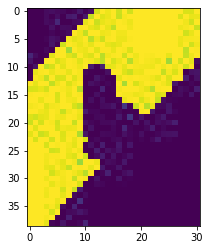

In [17]:
%matplotlib inline

image = PIL.Image.open(directory + 'group77000/77000/77000012_test.jpg')
crop_area = [365,128,396,167]
image = image.crop(crop_area)
plt.imshow(np.asarray(image))

# Get Labels

In [13]:
txt = pd.read_csv(directory + train_txt_files[1], delimiter= " ", header=None)
txt

,0,1,2,3,4
0,265,207,317,252,2
1,365,128,396,167,4
2,467,232,497,264,6
3,240,401,287,453,5
4,73,601,101,639,2


# Prepare Image and Labels

In [29]:
os.makedirs('/tmp/PCBdefects')

In [36]:
count = 0
class_labels = []

for txt in train_txt_files:

    read_txt = pd.read_csv(directory + txt, delimiter= " ", header=None)
    img_path = txt.replace("_not","").replace(".txt","_test.jpg")

    for i in range (len(read_txt)):

        label = read_txt.iloc[i][4]
        class_labels.append(label)

        crop_area = read_txt.iloc[i][:4]
        image = PIL.Image.open(directory + img_path)
        image = image.crop(crop_area)
        image.save('/tmp/PCBdefects/defect' + str(count) + '_' + str(label) + '.jpg')
        count = count + 1

1